In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import argmax
from pandas import DataFrame

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
import mglearn

In [3]:
def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation score of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    
    scores = cross_validate(model, X, y, cv = 7, scoring = 'average_precision',
                       return_train_score=True)
    
    mean_training = "{:.3f}".format(scores["train_score"].mean())
    
    mean_validation = "{:.3f}".format(scores["test_score"].mean())
    
    
    
    return mean_training, mean_validation

In [4]:
def print_grid_search_result(grid_search):
    '''Prints best parameters and mean training and validation scores of a grid search object.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        scores are printed with 3 decimal places.
        
    '''
    print(grid_search.best_params_)
    
    trainScore = "{:.3f}".format(grid_search.cv_results_['mean_train_score'][grid_search.best_index_])
    testScore =  "{:.3f}".format(grid_search.cv_results_['mean_test_score'][grid_search.best_index_])
    print("The Train Score is ", trainScore)
    print("The Test Score is ", testScore)

In [5]:


def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [6]:
def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    
    '''
    
    disp = confusion_matrix(y_actual, y_pred, labels = [0,1])
    
    
    df_cm = pd.DataFrame(disp, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True,fmt='g')
    plt.title(title)
    
    #TODO: implement function body

## Introduction

In this competition sponsored by Kaggle, my question is to answer, what sorts of people were more likely to survive the Titanic sinking? To accomplish this, my goal is to use machine learning and all of the models provided by sklearn to predict which passengers survived the Titanic using a test set data provided. In the training data.csv provided, we have several headers as illustrated below that will become our key features for our models.

![alt text](Data_Information.png "Data Information")

At first glance, we can see that the column ticket can be removed from the data set as it is safe to say that your ticket number has no impact by itself on whether or not you would survive the Titanic. All of the other ones seem useful for now. As embarked might place certain passengers on different and maybe safer parts of the ship.

In [7]:
#Loading in our dataset
data_train = pd.read_csv('train.csv')
data_test  = pd.read_csv('test.csv')

In [8]:
data_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [9]:
data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## Preprocessing

### Filling of Data

In [10]:
print('Train columns with null values:\n', data_train.isnull().sum())
print('Test columns with null values:\n', data_test.isnull().sum())

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Test columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Looking at our data we will need to clean some of it as some important columns have null values such as Age, Cabin, Embarked and Fare.

We make the assumption that we replace all null values for age from the average age of all passengers.
From the data, Embarked has only three ports represented by Q,S,C and for simplicity sake we will choose the most common one, Queenstown. We make the assumption that we replace all null values for age and fare from the averag fare and age of all passengers.

In [11]:
data_train["Age"].fillna(data_train["Age"].mean(),inplace = True)
data_train["Embarked"].fillna(data_train["Embarked"].mode()[0],inplace=True)

In [12]:
data_test["Fare"].fillna(data_test["Fare"].mean(),inplace = True)
data_test["Age"].fillna(data_test["Age"].mean(),inplace = True)

In [13]:
print('Train columns with null values:\n', data_train.isnull().sum())
print('Test columns with null values:\n', data_test.isnull().sum())

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64
Test columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


### Creating Our Labels

This next step since a lot of our headers are in string we will create numeric labels using preprocessing methods from sklearn. Next, we want to extract the titles from each name because that could prove useful in helping us determine if married people are more likely to survive than single people.

In [14]:
data_train["Title"] = data_train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
data_test["Title"] = data_test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [15]:
data_train["Title"]
pd.crosstab(data_train['Title'], data_train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [16]:
for data in [data_train, data_test] :
    data['Title'] = data['Title'].replace(['Lady', 'Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Interesting')
    data['Title'] = data['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royalty')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

In [17]:
pd.crosstab(data_test['Title'], data_train['Sex'])

Sex,female,male
Title,,
Interesting,1,5
Master,6,15
Miss,27,52
Mr,95,145
Mrs,31,41


We will divide our Age category into groups or bins and label each bin as appropriate.

In [18]:
for data in [data_train, data_test]:
    bins = [0,6,13,18,25,35,60, np.inf]
    labels = ["Baby","Child", "Teenager", "Young Adult","Adult","Middle Age", "Elderly"]
    data['AgeGroup'] = pd.cut(data["Age"], bins, labels = labels)

We will divide our Fare category into groups or bins and label each bin as appropriate.

In [19]:
for data in [data_train, data_test]:
    data['FareGroup'] = pd.qcut(data['Fare'], 6, labels = [1, 2, 3, 4, 5,6])

We will use a LabelEncoder to convert strings to integers and keep the encoder to translate between the representations for all Labels.

In [20]:
label = LabelEncoder()
for data in [data_train, data_test]:
    data['Sex_Label'] = label.fit_transform(data['Sex'])
    data['Title_Code'] = label.fit_transform(data['Title'])
    data['AgeBin_Code'] = label.fit_transform(data['AgeGroup'])
    data['FareGroup'] = label.fit_transform(data['FareGroup'])


Using mapping, we can quickly assign each port label into an integer.

In [21]:
for data in [data_train, data_test]:
    embarked_mapping = {"S": 1, "C": 2, "Q": 3}
    data['Embarked'] = data['Embarked'].map(embarked_mapping)

## Visualization

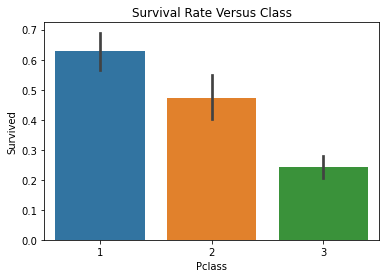

In [22]:
sns.barplot(x="Pclass", y="Survived", data=data_train)
plt.title("Survival Rate Versus Class")
plt.show()

This is an important feature to take note of as being in the first class indicates you had a higher chance of surviving the Titanic.

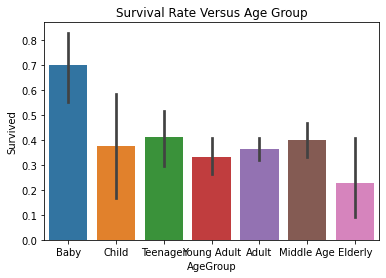

In [23]:
sns.barplot(x="AgeGroup", y="Survived", data=data_train)
plt.title("Survival Rate Versus Age Group")
plt.show()

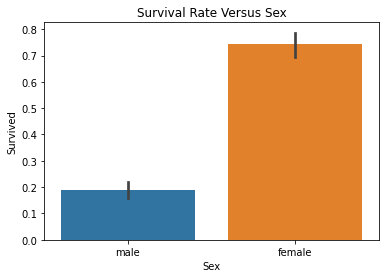

In [24]:
sns.barplot(x="Sex", y="Survived", data=data_train)
plt.title("Survival Rate Versus Sex")
plt.show()

Another Important feature where if you were a female you had over 70% chance of surviving.

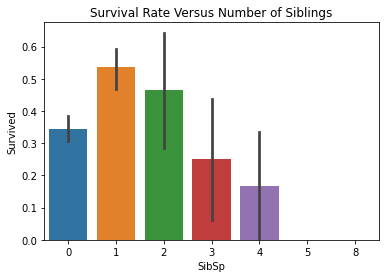

In [25]:
sns.barplot(x="SibSp", y="Survived", data=data_train)
plt.title("Survival Rate Versus Number of Siblings")
plt.show()

We can make the conclusion that if you had a high number of siblings chances are one of them or you wouldn't survive.

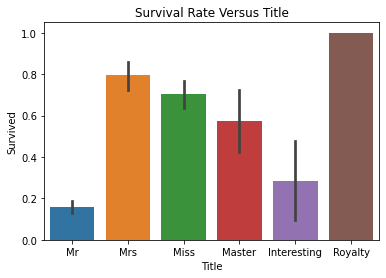

In [26]:
sns.barplot(x="Title", y="Survived", data=data_train)
plt.title("Survival Rate Versus Title")
plt.show()

One thing to indicate if you were a married woman you had a slightly higher chance of surviving than a single woman and also if you were a person with a royalty title you had a 100% chance of surviving.

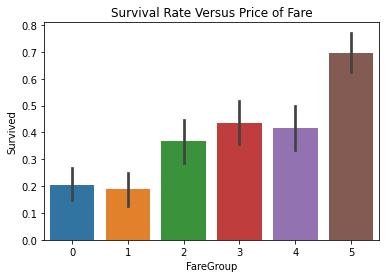

In [27]:
sns.barplot(x="FareGroup", y="Survived", data=data_train)
plt.title("Survival Rate Versus Price of Fare")
plt.show()

Here your odds of surviving increase if you paid more for your fare, but we can also interpret if you paid more for your fare, you were in the higher economic class.

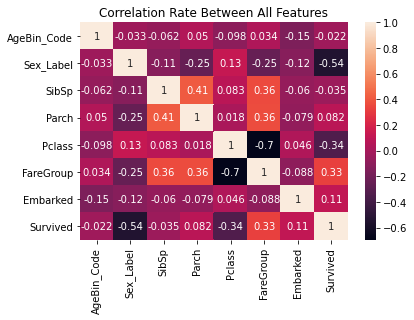

In [28]:
sns.heatmap(data_train[["AgeBin_Code","Sex_Label","SibSp","Parch","Pclass","FareGroup","Embarked", "Survived"]].corr(), annot = True)
plt.title("Correlation Rate Between All Features")
plt.show()

Here we can see very strong correlations for Sex_Label, PClass and FareGroup. With gender being the highest correlation out of all the features. Since we have transformed our labels we can drop predecessor columns from the dataset. I made the decision to drop Cabin from our dataset as there are over 650 null data values for our training set out of 890 to make an educated replacement. Although there should be some correlation between the location of where the passenger resides and the accessibility in escaping the Titanic.

In [29]:
for data in [data_train, data_test]:
    data.drop(['Name', 'Sex','Age'], axis = 1, inplace = True)
    data.drop(['Title'], axis = 1, inplace = True)
    data.drop(['AgeGroup'], axis = 1, inplace = True)
    data.drop(['Fare'], axis = 1, inplace = True)
    data.drop(['Cabin','Ticket'], axis = 1, inplace = True)

In [30]:
data_train

,PassengerId,Survived,Pclass,SibSp,Parch,Embarked,FareGroup,Sex_Label,Title_Code,AgeBin_Code
0,1,0,3,1,0,1,0,1,3,6
1,2,1,1,1,0,2,5,0,4,4
2,3,1,3,0,0,1,1,0,2,0
3,4,1,1,1,0,1,5,0,4,0
4,5,0,3,0,0,1,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,0,1,2,1,0,0
887,888,1,1,0,0,1,4,0,2,6
888,889,0,3,1,2,1,3,0,2,0
889,890,1,1,0,0,2,4,1,3,0


In [31]:
data_test

,PassengerId,Pclass,SibSp,Parch,Embarked,FareGroup,Sex_Label,Title_Code,AgeBin_Code
0,892,3,0,0,3,1,1,3,0
1,893,3,1,0,1,0,0,4,4
2,894,2,0,0,3,2,1,3,3
3,895,3,0,0,1,1,1,3,0
4,896,3,1,1,1,2,0,4,6
...,...,...,...,...,...,...,...,...,...
413,1305,3,0,0,1,1,1,3,0
414,1306,1,0,0,2,5,0,0,4
415,1307,3,0,0,1,0,1,3,4
416,1308,3,0,0,1,1,1,3,0


## Testing Our Models

For our problem set, we have a classification and regression problem set. Our end result is to predict based off a given list of characteristics and features whether or not a passenger survived the sinking. The second criteria is we are training our model with a provided dataset and therefore we have a Supervised Learning - Classification and Regression problem. The list of models I have chosen for this task are 
- LogisticRegression
- Support Vector Machines
- Gaussian Naive Bayes
- RandomForestClassifier
- GradientBoostingClassifier

In [32]:
predictors = data_train.drop(['Survived', 'PassengerId'], axis=1)
target = data_train["Survived"]
X_Train, X_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.2, random_state = 37)

In [33]:
lR = LogisticRegression()
sVM = SVC()
gNB = GaussianNB()
rF = RandomForestClassifier(random_state = 55)
gBC = GradientBoostingClassifier(random_state = 56)

for model in [rF, gBC, sVM, gNB, lR]:
     print("{} using all features: (Training and Validation Score) {}".format(model.__class__.__name__, 
                                             get_classifier_cv_score(model, X_Train, y_train)))

RandomForestClassifier using all features: (Training and Validation Score) ('0.947', '0.809')
GradientBoostingClassifier using all features: (Training and Validation Score) ('0.904', '0.850')
SVC using all features: (Training and Validation Score) ('0.837', '0.814')
GaussianNB using all features: (Training and Validation Score) ('0.780', '0.761')
LogisticRegression using all features: (Training and Validation Score) ('0.818', '0.810')


In [36]:
for model in [rF, gBC, sVM, gNB, lR]:
    model.fit(X_Train, y_train)
    y_pred = model.predict(X_val)
    acc_model = round(accuracy_score(y_pred, y_val) * 100, 2)
 
    print("{} using all features: Accuracy = {}".format(model.__class__.__name__, 
                                                                             acc_model))

RandomForestClassifier using all features: Accuracy = 78.77
GradientBoostingClassifier using all features: Accuracy = 82.68
SVC using all features: Accuracy = 79.89
GaussianNB using all features: Accuracy = 81.01
LogisticRegression using all features: Accuracy = 79.89


Here is a summary of our best to worst performing models in terms of score and accuracy. We can see the RandomForest and GradientBoosting are our best scoring wise and Gradient and GaussianNB are our most accurate.

| Model | Training Score | Validation Score | 
| :- | -: | -: |
| RandomForestClassifier | 0.947 | 0.809 |
| GradientBoostingClassifier | 0.904 | 0.850 |
| SVC | 0.837 | 0.814 |
| LogisticRegression | 0.818 | 0.810 |
| GaussianNB | 0.780 | 0.761 | 

| Model | Accuracy | 
| --- | -: |
| GradientBoostingClassifier | 82.68 | 
| GaussianNB | 81.01 |
| SVC | 79.89 |
| LogisticRegression |79.89 |
| RandomForestClassifier | 78.77 |




## HyperTuning our Models

### Grid Search ForRandomForestClassifer

In [37]:
param_grid = {'n_estimators': [100, 300, 500, 700],
             'max_depth' : [5, 7, 9, 11]}

grid = GridSearchCV(RandomForestClassifier(random_state=55), param_grid, scoring='average_precision',
                   cv=7, n_jobs=4, return_train_score=True)

In [38]:
grid.fit(X_Train, y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=55), n_jobs=4,
             param_grid={'max_depth': [5, 7, 9, 11],
                         'n_estimators': [100, 300, 500, 700]},
             return_train_score=True, scoring='average_precision')

In [39]:
print_grid_search_result(grid)

{'max_depth': 7, 'n_estimators': 300}
The Train Score is  0.917
The Test Score is  0.844


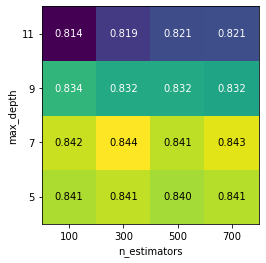

In [40]:
plot_grid_search_results(grid)

### Grid Search For GradientBoostingClassifer

In [41]:
param_grids = {'n_estimators': [25,50,100,200],
             'learning_rate' : [0.001, 0.01, 0.1, 1.0]}

grids = GridSearchCV(GradientBoostingClassifier(random_state=56), param_grids, scoring='accuracy',
                   cv=7, n_jobs=4, return_train_score=True)

In [42]:
grids.fit(X_Train, y_train)

GridSearchCV(cv=7, estimator=GradientBoostingClassifier(random_state=56),
             n_jobs=4,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [25, 50, 100, 200]},
             return_train_score=True, scoring='accuracy')

In [43]:
print_grid_search_result(grids)

{'learning_rate': 0.1, 'n_estimators': 100}
The Train Score is  0.873
The Test Score is  0.834


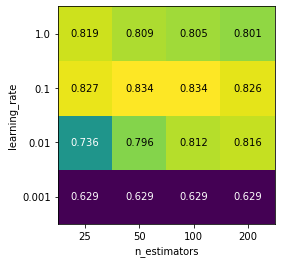

In [44]:
plot_grid_search_results(grids)

### Grid Search For SVC

In [45]:
param_SVC = {'C': [0.0001, 0.001, 0.01, 0.1],
             'gamma' : [0.1, 1.0, 10, 100]}

gridSVC = GridSearchCV(SVC(), param_SVC, scoring='average_precision',
                   cv=7, n_jobs=4, return_train_score=True)

In [46]:
gridSVC.fit(X_Train,y_train)

GridSearchCV(cv=7, estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1],
                         'gamma': [0.1, 1.0, 10, 100]},
             return_train_score=True, scoring='average_precision')

In [47]:
print_grid_search_result(gridSVC)

{'C': 0.0001, 'gamma': 1.0}
The Train Score is  0.894
The Test Score is  0.771


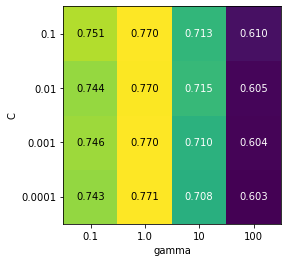

In [48]:
plot_grid_search_results(gridSVC)

In [49]:
print_grid_search_result(gridSVC)

{'C': 0.0001, 'gamma': 1.0}
The Train Score is  0.894
The Test Score is  0.771


## Precision Recall Curve

In [50]:
y_pred_prob = cross_val_predict(RandomForestClassifier(random_state=55, max_depth =7, n_estimators = 300), X_Train, y_train, cv =7, method='predict_proba')
y_pred_prob

array([[0.89008256, 0.10991744],
       [0.89907944, 0.10092056],
       [0.90736307, 0.09263693],
       ...,
       [0.56856953, 0.43143047],
       [0.87506956, 0.12493044],
       [0.86691013, 0.13308987]])

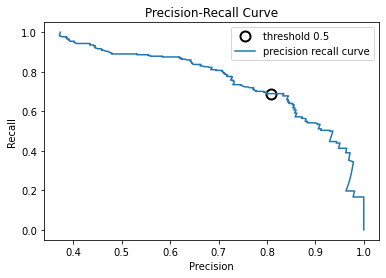

In [51]:
precision, recall, thresholds = precision_recall_curve(
    y_train, y_pred_prob[:,1])

desired_thresholds = 0.49999999
idx = np.argwhere(thresholds>desired_thresholds)[0]

#TODO: Plot precision-recall curve
plt.plot(precision[idx], recall[idx], 'o', markersize=10,
         label="threshold 0.5", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")
plt.title("Precision-Recall Curve")
plt.show()

## Retrain Our Models 

### RandomForestClassifier Retrain

In [52]:
rFD = RandomForestClassifier(max_depth=7, n_estimators=300, random_state=55)
rFD.fit(X_Train,y_train)

RandomForestClassifier(max_depth=7, n_estimators=300, random_state=55)

### Classification Report

In [53]:
y_pred = rFD.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.85       101
           1       0.84      0.72      0.77        78

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



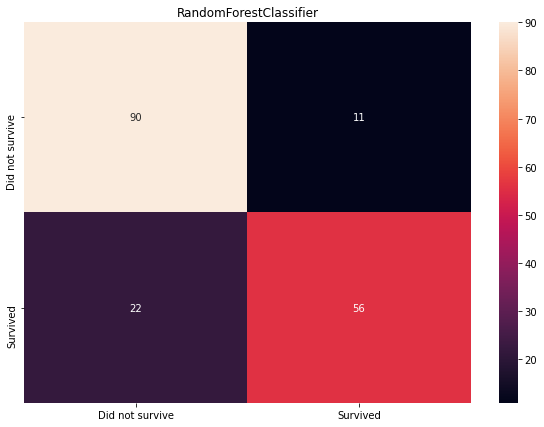

In [54]:
labels = ['Did not survive', 'Survived']
plot_confusion_matrix(y_val, y_pred, labels, title = "RandomForestClassifier")

In [55]:
desired_recall = 0.95
idx = np.argwhere(recall>desired_recall)[-1][0]
y_pred_lower_threshold = rFD.predict_proba(X_val)[:, 1] > thresholds[idx]

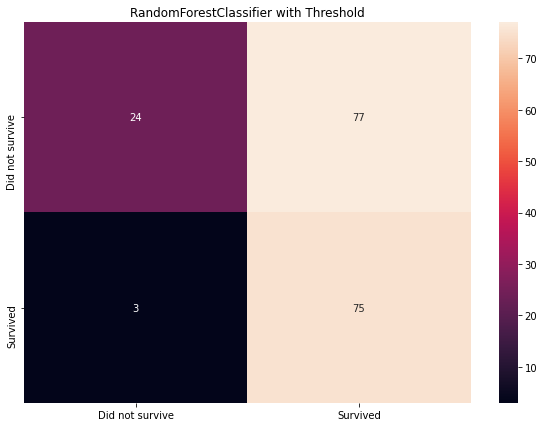

In [56]:
plot_confusion_matrix(y_val, y_pred_lower_threshold, labels, title = "RandomForestClassifier with Threshold")

### GradientBoostingClassifier Retrain

In [57]:
gBC = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, random_state = 123)
gBC.fit(X_Train,y_train)

GradientBoostingClassifier(random_state=123)

### Classification Report

In [58]:
y_pred = gBC.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       101
           1       0.87      0.71      0.78        78

    accuracy                           0.83       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179



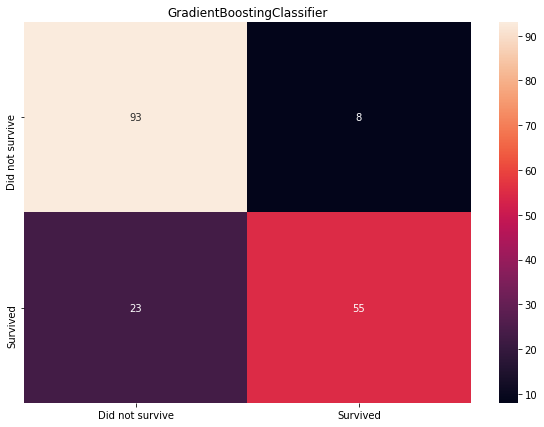

In [59]:
labels = ['Did not survive', 'Survived']
plot_confusion_matrix(y_val, y_pred, labels, title = "GradientBoostingClassifier")

### SVC Retrain

In [60]:
sVM = SVC(C = 0.0001, gamma = 1.0)
sVM.fit(X_Train,y_train)

SVC(C=0.0001, gamma=1.0)

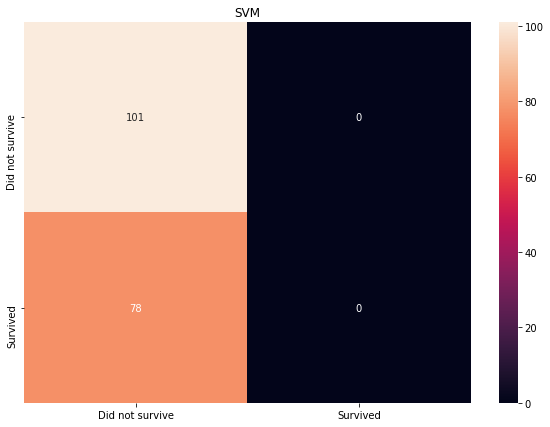

In [61]:
y_pred = sVM.predict(X_val)
labels = ['Did not survive', 'Survived']
plot_confusion_matrix(y_val, y_pred, labels, title = "SVM")

### New Accuracy with Retrained Models


In [62]:
for model in [rFD, gBC, sVM]:
     print("{} using all features: (Training and Validation Score) {}".format(model.__class__.__name__, 
                                             get_classifier_cv_score(model, X_Train, y_train)))

RandomForestClassifier using all features: (Training and Validation Score) ('0.917', '0.844')
GradientBoostingClassifier using all features: (Training and Validation Score) ('0.905', '0.850')
SVC using all features: (Training and Validation Score) ('0.894', '0.771')


In [63]:
for model in [rFD, gBC,sVM]:
    y_pred = model.predict(X_val)
    acc_model = round(accuracy_score(y_pred, y_val) * 100, 2)
 
    print("{} using all features: Accuracy = {}".format(model.__class__.__name__, 
                                                                             acc_model))

RandomForestClassifier using all features: Accuracy = 81.56
GradientBoostingClassifier using all features: Accuracy = 82.68
SVC using all features: Accuracy = 56.42


| Model | Training Score | Validation Score | 
| :- | -: | -: |
| GradientBoostingClassifier | 0.904 | 0.850 |
| SVC | 0.837 | 0.814 |
| RandomForestClassifier | 0.947 | 0.809 |

| Model | Accuracy | 
| --- | -: |
| GradientBoostingClassifier | 82.68 | 
| RandomForestClassifier | 81.56 |
| SVC | 56.42 |


### Results for Competition

In [64]:
ids = data_test['PassengerId']
predictions = rFD.predict(data_test.drop('PassengerId', axis=1))

#set the output as a dataframe and convert to csv file named submission.csv
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('submission.csv', index=False)

![alt text](results.png "Results")

## Conclusion

### What types of people were likely to survive the Titanic?

Results from the visualization section of our report show 
- Gender was a significant indicator in determine if a passenger survived as over 70% of the females survived where as less than 20% of the males survived.
- Small sample size were if you are a person of royal background i.e having titles such as Sir, Lady, or Countess you had a 100% chance of surviving the wreck.
- Only significant indicator for age group was for individuals aged 0-5 years had just under 70% chance of survival.
- Persons belonging in First class had double the chance over persons belonging in the lowest class.

### Results

From our research proposal, our goal was to compete in the Titanic Machine Learning Competition and to be able to successfully predict results from my trained model. With my results submitted, I achieved a score of 0.77272 which means my model was able to predict 77.3% of the passengers from the test set correctly. I believe these results to be quite excellent for a beginner Data Scientist/Machine Learning designer as I still have less than four months of experience. With my score I placed in the top 61% of all competitors. The model I concluded to be my best performing one is the Gradient Boosting Classifier as it scored the highest accuracy amongst the chosen three after I hypertuned the parameters. Using methods developed from assignments during the semester, I used cross-validation during the initial running of my models with no parameters set for any of them. A summary of those results can be shown below:

#### Scores Before Grid Search 
***
| Model | Training Score | Validation Score | 
| :- | -: | -: |
| RandomForestClassifier | 0.947 | 0.809 |
| GradientBoostingClassifier | 0.904 | 0.850 |
| SVC | 0.837 | 0.814 |
| LogisticRegression | 0.818 | 0.810 |
| GaussianNB | 0.780 | 0.761 | 


| Model | Accuracy | 
| --- | -: |
| GradientBoostingClassifier | 82.68 | 
| GaussianNB | 81.01 |
| SVM | 79.89 |
| LogisticRegression |79.89 |
| RandomForestClassifier | 78.77 |

#### Scores After Grid Search 
***
| Model | Training Score | Validation Score | 
| :- | -: | -: |
| GradientBoostingClassifier | 0.904 | 0.850 |
| SVC | 0.837 | 0.814 |
| RandomForestClassifier | 0.947 | 0.809 |

| Model | Accuracy | 
| --- | -: |
| GradientBoostingClassifier | 82.68 | 
| RandomForestClassifier | 81.56 |
| SVC | 56.42 |


With the grid search, we can see that the accuracy of our RandomForestClassifier model improved by almost 3 points where as our SVM model was improperly tuned as the accuracy dipped almost 25 points.

After performing the grid search for our top three models, I included a Precision-Recall Curve for our RandomForest model to find better thresholds for high recall results. However it seems that for this problem and looking at our confusion matrix with the adjust threshold obtained from the precision-recall curve we produced 50% more True positive results (survived) but an unacceptable amount of false positives as well. Default threshold : 55 true positive and 8 false positives, Adjusted threshold: 75 true positives and 77 false positives.

## Reflection

I think my report here accurately followed my project proposal. I was able to submit a successful submission to Kaggle and achieve an acceptable personal score for the purposes of this project and problem set. However one section I will discuss is the precision-recall curve. Comparing the graph I obtained with the one used in Lab 3 my results were more inaccurate after retrieving a threshold value for my confusion matrix for the RandomForestClassifier. This has been an excellent learning opportunity and I am glad I selected this for my machine learning project for this class. From this project I learned that preprocess of the data is just as important as the fine-tuning of the models as cleaning and correlating your features together can produce accurate scores from your model. I would like to thank Dr. Yves Pauchard for beling an excellent professor and role model for my first class in Machine Learning!